In [1]:
import numpy as np
import pandas as pd
import os
pd.set_option('display.max_columns', None)
from sklearn.linear_model import Lasso,SGDRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV,train_test_split
from sklearn.ensemble import RandomForestRegressor,ExtraTreesRegressor,BaggingRegressor,VotingRegressor,GradientBoostingRegressor,AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler,MinMaxScaler,OneHotEncoder,OrdinalEncoder,LabelEncoder
from sklearn.base import BaseEstimator,TransformerMixin
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.tree import DecisionTreeRegressor
from sklearn.feature_selection import SelectFromModel
from date_transformer import DateTransformer


for dirname,_,filenames in os.walk("dataset"):
    for filename in filenames:
        print(os.path.join(dirname,filename))

dataset/Data_Train.xlsx
dataset/Test_set.xlsx
dataset/Sample_submission.xlsx


In [2]:
data = pd.read_excel(r"dataset/Data_Train.xlsx")
airline = data.copy()
airline

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302
...,...,...,...,...,...,...,...,...,...,...,...
10678,Air Asia,9/04/2019,Kolkata,Banglore,CCU → BLR,19:55,22:25,2h 30m,non-stop,No info,4107
10679,Air India,27/04/2019,Kolkata,Banglore,CCU → BLR,20:45,23:20,2h 35m,non-stop,No info,4145
10680,Jet Airways,27/04/2019,Banglore,Delhi,BLR → DEL,08:20,11:20,3h,non-stop,No info,7229
10681,Vistara,01/03/2019,Banglore,New Delhi,BLR → DEL,11:30,14:10,2h 40m,non-stop,No info,12648


In [3]:
airline.isnull().sum()

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              1
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        1
Additional_Info    0
Price              0
dtype: int64

In [4]:
airline.dropna(inplace=True)

In [5]:
airline.isnull().sum()

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              0
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        0
Additional_Info    0
Price              0
dtype: int64

In [6]:
airline.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302


In [7]:
airline['Airline'].value_counts()

Jet Airways                          3849
IndiGo                               2053
Air India                            1751
Multiple carriers                    1196
SpiceJet                              818
Vistara                               479
Air Asia                              319
GoAir                                 194
Multiple carriers Premium economy      13
Jet Airways Business                    6
Vistara Premium economy                 3
Trujet                                  1
Name: Airline, dtype: int64

In [8]:
airline['Source'].value_counts()

Delhi       4536
Kolkata     2871
Banglore    2197
Mumbai       697
Chennai      381
Name: Source, dtype: int64

In [9]:
airline['Destination'].value_counts()

Cochin       4536
Banglore     2871
Delhi        1265
New Delhi     932
Hyderabad     697
Kolkata       381
Name: Destination, dtype: int64

In [10]:
airline['Total_Stops'].value_counts()

1 stop      5625
non-stop    3491
2 stops     1520
3 stops       45
4 stops        1
Name: Total_Stops, dtype: int64

In [11]:
airline['Additional_Info'].value_counts()

No info                         8344
In-flight meal not included     1982
No check-in baggage included     320
1 Long layover                    19
Change airports                    7
Business class                     4
No Info                            3
Red-eye flight                     1
1 Short layover                    1
2 Long layover                     1
Name: Additional_Info, dtype: int64

In [12]:
o = OrdinalEncoder()
new_f = o.fit_transform(airline[['Total_Stops','Additional_Info']][:10])
new_f

array([[2., 1.],
       [1., 1.],
       [1., 1.],
       [0., 1.],
       [0., 1.],
       [2., 1.],
       [0., 0.],
       [0., 1.],
       [0., 0.],
       [0., 1.]])

In [13]:
o.inverse_transform(new_f)

array([['non-stop', 'No info'],
       ['2 stops', 'No info'],
       ['2 stops', 'No info'],
       ['1 stop', 'No info'],
       ['1 stop', 'No info'],
       ['non-stop', 'No info'],
       ['1 stop', 'In-flight meal not included'],
       ['1 stop', 'No info'],
       ['1 stop', 'In-flight meal not included'],
       ['1 stop', 'No info']], dtype=object)

In [14]:
one_hot = OneHotEncoder()
new_f = one_hot.fit_transform(airline[['Total_Stops']])
new_f

<10682x5 sparse matrix of type '<class 'numpy.float64'>'
	with 10682 stored elements in Compressed Sparse Row format>

In [15]:
one_hot.inverse_transform(new_f)

array([['non-stop'],
       ['2 stops'],
       ['2 stops'],
       ...,
       ['non-stop'],
       ['non-stop'],
       ['2 stops']], dtype=object)

In [28]:
counts = airline['Destination'].value_counts()
new_df = airline.loc[airline['Destination'].isin(counts.index[counts > 10])]
new_df['Additional_Info'].value_counts()

No info                         8337
In-flight meal not included     1982
No check-in baggage included     320
1 Long layover                    19
Name: Additional_Info, dtype: int64

In [17]:
airline.shape

(10682, 11)

In [18]:


class RareCategories(BaseEstimator,TransformerMixin):
    """
    delete rare categories with unknown , less than threshold
    if threshold is in fraction , then replace the percent of categories
    else take absolute number
    """
    def __init__(self,threshold=10):
        self.threshold = threshold
    def fit(self,X,y=None):
        return self
    def transform(self,X,y=None):
        newx = X.copy()
        for f in newx.columns:
            if (newx[f].dtype == 'object' or newx[f].dtype == 'O') and len(newx[f].unique()) < 30:
            #newx.drop(index = self.rare_dict[f],inplace=True,errors='ignore')
                #print(f)
                counts = newx[f].value_counts()
                newx = newx.loc[newx[f].isin(counts.index[counts > self.threshold])]
            #newx[f] = np.where(newx[f].isin(self.rare_dict[f]),'RARE',newx[f])
        return newx
    
airline = RareCategories().fit_transform(airline)
airline

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302
...,...,...,...,...,...,...,...,...,...,...,...
10678,Air Asia,9/04/2019,Kolkata,Banglore,CCU → BLR,19:55,22:25,2h 30m,non-stop,No info,4107
10679,Air India,27/04/2019,Kolkata,Banglore,CCU → BLR,20:45,23:20,2h 35m,non-stop,No info,4145
10680,Jet Airways,27/04/2019,Banglore,Delhi,BLR → DEL,08:20,11:20,3h,non-stop,No info,7229
10681,Vistara,01/03/2019,Banglore,New Delhi,BLR → DEL,11:30,14:10,2h 40m,non-stop,No info,12648


In [488]:
X_train,X_test,y_train,y_test = train_test_split(airline.drop('Price',axis=1),airline['Price'].copy(),test_size=0.2,random_state=42)
X_train.shape

(8526, 10)

In [30]:
airline.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302


In [489]:
X_train.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info
7653,Air India,12/06/2019,Kolkata,Banglore,CCU → DEL → BLR,17:30,20:25 13 Jun,26h 55m,1 stop,No info
3045,Multiple carriers,9/04/2019,Delhi,Cochin,DEL → BOM → COK,10:35,19:15,8h 40m,1 stop,No info
4066,SpiceJet,21/03/2019,Mumbai,Hyderabad,BOM → HYD,22:45,00:10 22 Mar,1h 25m,non-stop,No info
2489,Jet Airways,6/03/2019,Delhi,Cochin,DEL → BOM → COK,08:00,04:25 07 Mar,20h 25m,1 stop,In-flight meal not included
6735,Jet Airways,9/06/2019,Delhi,Cochin,DEL → JAI → BOM → COK,19:30,04:25 10 Jun,8h 55m,2 stops,No info


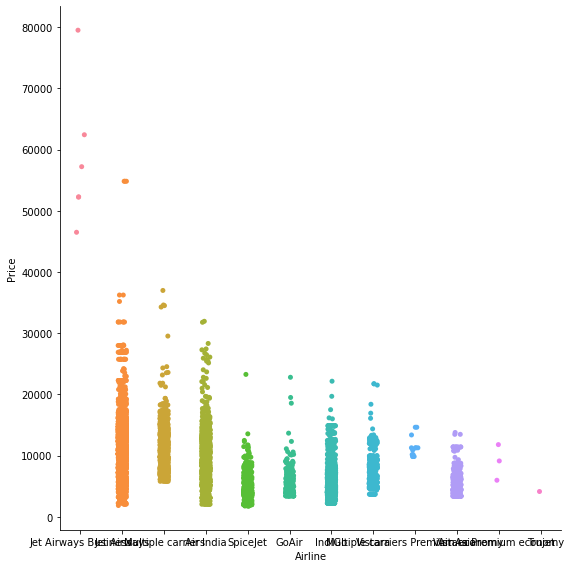

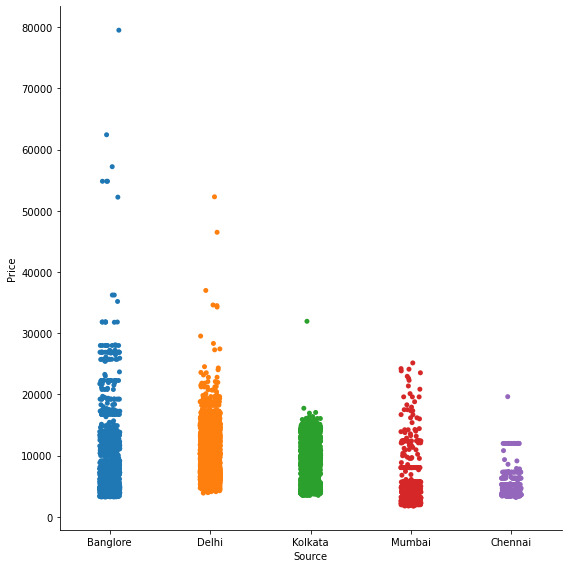

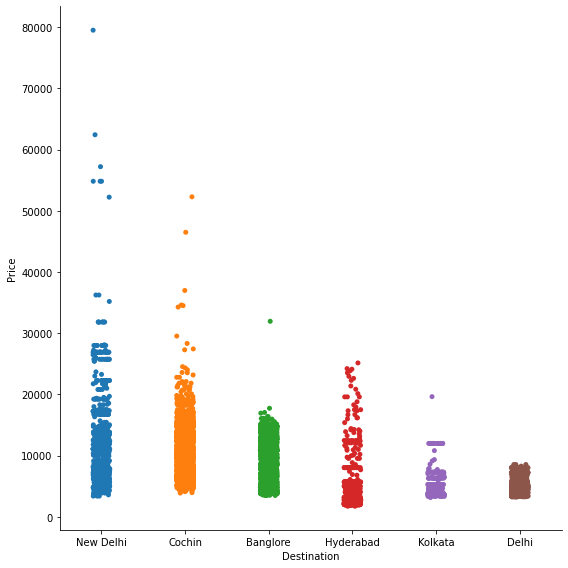

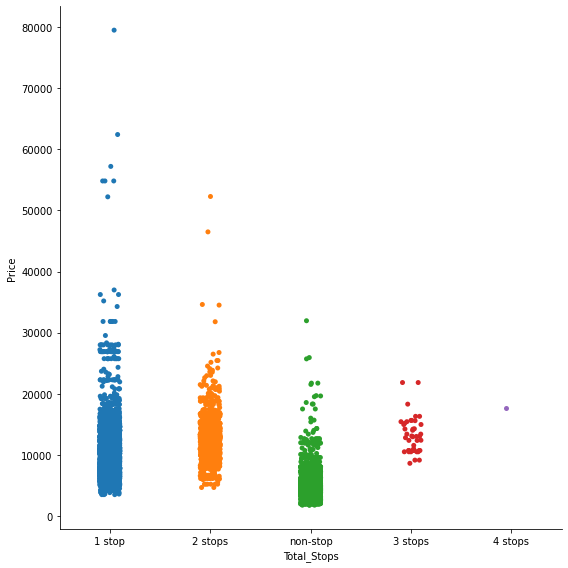

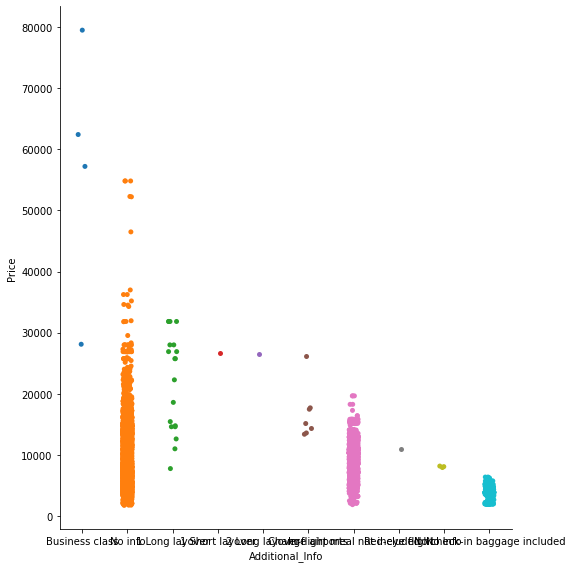

In [78]:
cat_features = ['Airline','Source','Destination','Total_Stops','Additional_Info']
for f in cat_features:
    sns.catplot(x=f,y='Price',data=airline.sort_values('Price',ascending=False),height=8)
    #airline.groupby(f)['Price'].mean().plot.bar()
    plt.show()

In [415]:
instances = X_train.groupby('Airline')['Airline'].count()
instances[instances < 10].index
X_train.drop(index=instances[instances < 10].index,columns=['Airline'])

KeyError: "['Jet Airways Business' 'Trujet' 'Vistara Premium economy'] not found in axis"

In [478]:


RareCategories(threshold=10).fit_transform(X_train)['Additional_Info'].value_counts()

No info                         6708
In-flight meal not included     1549
No check-in baggage included     254
1 Long layover                    15
Name: Additional_Info, dtype: int64

In [479]:
X_train['Airline'].dtype == 'O'

True

In [490]:

            

cat_pipeline = ColumnTransformer([
    ('one_hot',OneHotEncoder(),['Airline','Source','Destination']),
    ('ordinal_encoder',OrdinalEncoder(),['Total_Stops','Additional_Info']),
    ('drop_features','drop',['Route'])
])

pd.DataFrame(cat_pipeline.fit_transform(X_train).toarray())

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,3.0,3.0
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8521,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,3.0,3.0
8522,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3.0
8523,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,3.0
8524,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3.0


In [29]:
X_train.head()

NameError: name 'X_train' is not defined

In [144]:
DateTransformer().fit_transform(X_train)

,Airline,Source,Destination,Route,Total_Stops,Additional_Info,Date_of_Journey_year,Date_of_Journey_month,Date_of_Journey_day,Dep_Time_hour,Dep_Time_minute,Arrival_Time_hour,Arrival_Time_minute,Duration_hour,Duration_min
10005,Multiple carriers,Delhi,Cochin,DEL → BOM → COK,1 stop,No info,1,5,27,8,30,19,15,10,45
3684,Jet Airways,Delhi,Cochin,DEL → BOM → COK,1 stop,In-flight meal not included,1,9,5,11,30,12,35,25,5
1034,SpiceJet,Delhi,Cochin,DEL → MAA → COK,1 stop,No info,1,4,24,15,45,22,5,6,20
3909,Multiple carriers,Delhi,Cochin,DEL → BOM → COK,1 stop,No info,1,3,21,12,50,1,35,12,45
3088,Air India,Delhi,Cochin,DEL → HYD → BOM → COK,2 stops,No info,1,6,24,17,15,19,15,26,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5734,Jet Airways,Delhi,Cochin,DEL → BOM → COK,1 stop,No info,1,3,27,9,0,4,25,19,25
5191,Jet Airways,Kolkata,Banglore,CCU → BOM → BLR,1 stop,In-flight meal not included,1,9,5,14,5,20,45,6,40
5390,Multiple carriers,Delhi,Cochin,DEL → BOM → COK,1 stop,No info,1,5,15,12,50,1,30,12,40
860,IndiGo,Banglore,New Delhi,BLR → DEL,non-stop,No info,1,3,3,0,40,3,25,2,45


In [491]:
preprocess_pipeline = Pipeline([
    ('date_attribs',DateTransformer()),
    ('cat_attribs',cat_pipeline)
])

In [477]:
pd.DataFrame(preprocess_pipeline.fit_transform(X_train).toarray())

Airline
Source
Destination
Total_Stops
Additional_Info
Duration_min


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8521,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
8522,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
8523,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
8524,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0


Preprocessing is done,lets move on to the feature selection and model

In [171]:
ext_tree = ExtraTreesRegressor(n_estimators=3000).fit(preprocess_pipeline.transform(X_train),y_train)
ext_tree.score(preprocess_pipeline.transform(X_test),y_test)

0.717501570540346

In [172]:
ext_tree.feature_importances_

array([3.26204300e-03, 1.16807541e-02, 1.62243737e-03, 1.78678352e-02,
       1.33541838e-01, 9.04237250e-02, 2.89773345e-02, 1.32514539e-03,
       4.93767453e-03, 1.97949606e-04, 6.57219707e-03, 1.89860525e-04,
       9.95263964e-03, 4.91197688e-05, 4.52318682e-03, 1.98886500e-03,
       6.59045276e-03, 1.95781636e-03, 4.80994135e-03, 3.38753697e-03,
       6.44882737e-03, 4.82365420e-05, 1.83942245e-02, 5.11540352e-01,
       1.29710006e-01])

In [183]:
np.sort(ext_tree.feature_importances_)[::-1]


array([5.11540352e-01, 1.33541838e-01, 1.29710006e-01, 9.04237250e-02,
       2.89773345e-02, 1.83942245e-02, 1.78678352e-02, 1.16807541e-02,
       9.95263964e-03, 6.59045276e-03, 6.57219707e-03, 6.44882737e-03,
       4.93767453e-03, 4.80994135e-03, 4.52318682e-03, 3.38753697e-03,
       3.26204300e-03, 1.98886500e-03, 1.95781636e-03, 1.62243737e-03,
       1.32514539e-03, 1.97949606e-04, 1.89860525e-04, 4.91197688e-05,
       4.82365420e-05])

lets check feature importance with lasso regression

In [216]:
sgd = SelectFromModel(SGDRegressor(penalty="l1",alpha=1),threshold="median").fit(preprocess_pipeline.transform(X_train),y_train)
sgd.get_support().sum()

13

In [217]:
sgd.estimator_.coef_ 

array([-2346.31046061,   813.27207318, -2267.44828991, -2230.01269071,
        3760.57989554,  8065.71010096,   935.10096498,   257.89040314,
       -2194.27999276,     0.        ,  -222.60862487,     0.        ,
        1312.63281665,   696.06178662,  1001.62959105,   700.83961168,
        -104.51976257,   700.83961168,  1001.62959105,  -965.27649097,
        -104.51976257,   696.06178662,  2588.92453276,  -702.35485854,
        1030.57822592])

In [280]:
sgd_reg = SGDRegressor(penalty="l1",alpha=1e-4).fit(preprocess_pipeline.transform(X_train),y_train)

In [281]:
sgd_reg.score(preprocess_pipeline.transform(X_train),y_train)

0.5562148937928526

In [223]:
np.sqrt(mean_squared_error(sgd_reg.predict(preprocess_pipeline.transform(X_test)),y_test))

3036.774461338396

In [354]:
rnd = SelectFromModel(RandomForestRegressor(n_estimators=100),threshold="0.05*mean").fit(preprocess_pipeline.transform(X_train),y_train)


In [355]:
rnd.get_support().sum()

18

In [283]:
np.sqrt(mean_squared_error(rnd.predict(preprocess_pipeline.transform(X_train)),y_train))

2373.3844126476765

In [286]:
rnd.feature_importances_

array([2.32516835e-03, 9.86261059e-03, 1.27318906e-03, 2.53740893e-02,
       9.65548630e-02, 8.49949211e-02, 3.21235426e-02, 1.23629441e-03,
       4.68660176e-03, 2.09820572e-04, 5.25081365e-03, 1.54081116e-04,
       1.07561649e-02, 1.96557165e-04, 3.91363389e-03, 2.06351478e-03,
       6.59630660e-03, 2.13547192e-03, 3.78938690e-03, 4.90641403e-04,
       6.40419545e-03, 2.19089135e-04, 1.84742992e-02, 5.52396319e-01,
       1.28518424e-01])

In [266]:

estimators = [
    ('rnd' , RandomForestRegressor(n_estimators=1000)),
    ('grad' , GradientBoostingRegressor()),
    ('decision',DecisionTreeRegressor())
    ('linear',SGDRegressor(penalty="l1"))
]
vote = VotingRegressor(estimators).fit(preprocess_pipeline.transform(X_train),y_train)


In [267]:
np.sqrt(mean_squared_error(vote.predict(preprocess_pipeline.transform(X_test)),y_test))

2466.217268649823

In [268]:
[np.sqrt(mean_squared_error(estimator.predict(preprocess_pipeline.transform(X_test)),y_test)) for estimator in vote.estimators_]

[2479.987313922991, 2478.139628322792]

In [505]:
final_pipeline = Pipeline([
    ('preprocess',preprocess_pipeline),
    ('feature_select',SelectFromModel(RandomForestRegressor(n_estimators=500),threshold="0.05*mean")),
    ('random_forest',RandomForestRegressor(n_estimators=100))
])

final_pipeline_dec = Pipeline([
    ('preprocess',preprocess_pipeline),
    ('feature_select',SelectFromModel(RandomForestRegressor(n_estimators=500),threshold="0.05*mean")),
    ('random_forest',DecisionTreeRegressor())
])
#final_pipeline.fit(X_train,y_train)

In [377]:
final_pipeline.score(X_test,y_test)

0.7135218788290764

In [365]:
final_pipeline.predict(X_test[:5])

array([16220.01227354,  7650.38035916,  9287.4392003 ,  4516.437881  ,
       10647.80840793])

In [366]:
y_test[:5]

6075    16655
3544     4959
9291     9187
5032     3858
2483    12898
Name: Price, dtype: int64

In [367]:
final_pipeline.score(X_train,y_train)

0.7328935725870933

In [338]:
r = final_pipeline['random_forest']
r.estimator_params

('criterion',
 'max_depth',
 'min_samples_split',
 'min_samples_leaf',
 'min_weight_fraction_leaf',
 'max_features',
 'max_leaf_nodes',
 'min_impurity_decrease',
 'min_impurity_split',
 'random_state',
 'ccp_alpha')

In [314]:
RandomForestRegressor().

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

Hyper Parameter tuning

In [514]:
params_grid = [{
    'feature_select__threshold' : ["{}*mean".format(i) for i in np.random.uniform(low=0.01,high=0.2,size=5)],
    'random_forest__criterion' : ['mae','mse'],
    'random_forest__max_depth' : list(range(2,10,2))+[None],
    'random_forest__max_leaf_nodes' : list(range(2,10,2))+[None],
    'random_forest__random_state' : [42]
}]

#Randomized Search CV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1200, num = 12)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 30, num = 6)]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 15, 100]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 5, 10]

random_grid = {'random_forest__n_estimators': n_estimators,
               'random_forest__max_features': max_features,
               'random_forest__max_depth': max_depth,
               'random_forest__min_samples_split': min_samples_split,
               'random_forest__min_samples_leaf': min_samples_leaf}
random_search = RandomizedSearchCV(final_pipeline,random_grid,cv=5, scoring="neg_mean_squared_error",verbose=3,random_state=42)

In [515]:
random_search.fit(X_train,y_train)
random_search.best_params_

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] random_forest__n_estimators=900, random_forest__min_samples_split=5, random_forest__min_samples_leaf=5, random_forest__max_features=sqrt, random_forest__max_depth=10 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  random_forest__n_estimators=900, random_forest__min_samples_split=5, random_forest__min_samples_leaf=5, random_forest__max_features=sqrt, random_forest__max_depth=10, score=-6807871.412, total=   7.8s
[CV] random_forest__n_estimators=900, random_forest__min_samples_split=5, random_forest__min_samples_leaf=5, random_forest__max_features=sqrt, random_forest__max_depth=10 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.8s remaining:    0.0s


[CV]  random_forest__n_estimators=900, random_forest__min_samples_split=5, random_forest__min_samples_leaf=5, random_forest__max_features=sqrt, random_forest__max_depth=10, score=-5248421.394, total=   8.2s
[CV] random_forest__n_estimators=900, random_forest__min_samples_split=5, random_forest__min_samples_leaf=5, random_forest__max_features=sqrt, random_forest__max_depth=10 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   15.9s remaining:    0.0s


[CV]  random_forest__n_estimators=900, random_forest__min_samples_split=5, random_forest__min_samples_leaf=5, random_forest__max_features=sqrt, random_forest__max_depth=10, score=-5157369.159, total=   8.2s
[CV] random_forest__n_estimators=900, random_forest__min_samples_split=5, random_forest__min_samples_leaf=5, random_forest__max_features=sqrt, random_forest__max_depth=10 
[CV]  random_forest__n_estimators=900, random_forest__min_samples_split=5, random_forest__min_samples_leaf=5, random_forest__max_features=sqrt, random_forest__max_depth=10, score=-7307853.787, total=   7.6s
[CV] random_forest__n_estimators=900, random_forest__min_samples_split=5, random_forest__min_samples_leaf=5, random_forest__max_features=sqrt, random_forest__max_depth=10 
[CV]  random_forest__n_estimators=900, random_forest__min_samples_split=5, random_forest__min_samples_leaf=5, random_forest__max_features=sqrt, random_forest__max_depth=10, score=-6226784.160, total=   8.1s
[CV] random_forest__n_estimators=11

[CV]  random_forest__n_estimators=700, random_forest__min_samples_split=5, random_forest__min_samples_leaf=10, random_forest__max_features=auto, random_forest__max_depth=20, score=-6215736.504, total=   8.9s
[CV] random_forest__n_estimators=1000, random_forest__min_samples_split=2, random_forest__min_samples_leaf=1, random_forest__max_features=sqrt, random_forest__max_depth=25 
[CV]  random_forest__n_estimators=1000, random_forest__min_samples_split=2, random_forest__min_samples_leaf=1, random_forest__max_features=sqrt, random_forest__max_depth=25, score=-6319638.378, total=   9.4s
[CV] random_forest__n_estimators=1000, random_forest__min_samples_split=2, random_forest__min_samples_leaf=1, random_forest__max_features=sqrt, random_forest__max_depth=25 
[CV]  random_forest__n_estimators=1000, random_forest__min_samples_split=2, random_forest__min_samples_leaf=1, random_forest__max_features=sqrt, random_forest__max_depth=25, score=-5138427.294, total=   9.9s
[CV] random_forest__n_estimato

[CV]  random_forest__n_estimators=700, random_forest__min_samples_split=15, random_forest__min_samples_leaf=1, random_forest__max_features=auto, random_forest__max_depth=20, score=-5143270.595, total=   9.4s
[CV] random_forest__n_estimators=700, random_forest__min_samples_split=15, random_forest__min_samples_leaf=1, random_forest__max_features=auto, random_forest__max_depth=20 
[CV]  random_forest__n_estimators=700, random_forest__min_samples_split=15, random_forest__min_samples_leaf=1, random_forest__max_features=auto, random_forest__max_depth=20, score=-5065025.087, total=   9.0s
[CV] random_forest__n_estimators=700, random_forest__min_samples_split=15, random_forest__min_samples_leaf=1, random_forest__max_features=auto, random_forest__max_depth=20 
[CV]  random_forest__n_estimators=700, random_forest__min_samples_split=15, random_forest__min_samples_leaf=1, random_forest__max_features=auto, random_forest__max_depth=20, score=-6799871.905, total=   8.2s
[CV] random_forest__n_estimato

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  6.2min finished


{'random_forest__n_estimators': 700,
 'random_forest__min_samples_split': 15,
 'random_forest__min_samples_leaf': 1,
 'random_forest__max_features': 'auto',
 'random_forest__max_depth': 20}

In [521]:
random_grid = [{
    'feature_select__threshold' : ["{}*mean".format(i) for i in np.random.uniform(low=0.01,high=0.2,size=5)],
}]

rnd = GridSearchCV(random_search.best_estimator_,random_grid,cv=5, scoring="neg_mean_squared_error",verbose=3)
rnd.fit(X_train,y_train)
rnd.best_params_

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] feature_select__threshold=0.024199598213299468*mean .............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  feature_select__threshold=0.024199598213299468*mean, score=-6285454.087, total=   9.5s
[CV] feature_select__threshold=0.024199598213299468*mean .............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.5s remaining:    0.0s


[CV]  feature_select__threshold=0.024199598213299468*mean, score=-5132173.270, total=   9.9s
[CV] feature_select__threshold=0.024199598213299468*mean .............


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   19.4s remaining:    0.0s


[CV]  feature_select__threshold=0.024199598213299468*mean, score=-5030234.138, total=   9.4s
[CV] feature_select__threshold=0.024199598213299468*mean .............
[CV]  feature_select__threshold=0.024199598213299468*mean, score=-6732920.498, total=   9.3s
[CV] feature_select__threshold=0.024199598213299468*mean .............
[CV]  feature_select__threshold=0.024199598213299468*mean, score=-5963683.512, total=   9.2s
[CV] feature_select__threshold=0.014913734378366206*mean .............
[CV]  feature_select__threshold=0.014913734378366206*mean, score=-6283270.889, total=   9.6s
[CV] feature_select__threshold=0.014913734378366206*mean .............
[CV]  feature_select__threshold=0.014913734378366206*mean, score=-5137790.765, total=  10.5s
[CV] feature_select__threshold=0.014913734378366206*mean .............
[CV]  feature_select__threshold=0.014913734378366206*mean, score=-5028413.428, total=   9.9s
[CV] feature_select__threshold=0.014913734378366206*mean .............
[CV]  feature_se

[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:  3.7min finished


{'feature_select__threshold': '0.024199598213299468*mean'}

In [522]:
np.sqrt(-rnd.best_score_)

2414.310067306919

Pipeline(steps=[('preprocess',
                 Pipeline(steps=[('date_attribs', DateTransformer()),
                                 ('cat_attribs',
                                  ColumnTransformer(transformers=[('one_hot',
                                                                   OneHotEncoder(),
                                                                   ['Airline',
                                                                    'Source',
                                                                    'Destination']),
                                                                  ('ordinal_encoder',
                                                                   OrdinalEncoder(),
                                                                   ['Total_Stops',
                                                                    'Additional_Info']),
                                                                  ('drop_features',
                   

In [523]:
best_pipeline =  Pipeline([
    ('preprocess',preprocess_pipeline),
    ('feature_select',SelectFromModel(RandomForestRegressor(n_estimators=500),threshold='0.024199598213299468*mean')),
    ('random_forest',RandomForestRegressor(n_estimators=700,
                                           min_samples_split=15,
                                           min_samples_leaf=1,
                                           max_features='auto',
                                           max_depth=20 ))
])

In [524]:
best_pipeline.fit(X_train,y_train)

Pipeline(steps=[('preprocess',
                 Pipeline(steps=[('date_attribs', DateTransformer()),
                                 ('cat_attribs',
                                  ColumnTransformer(transformers=[('one_hot',
                                                                   OneHotEncoder(),
                                                                   ['Airline',
                                                                    'Source',
                                                                    'Destination']),
                                                                  ('ordinal_encoder',
                                                                   OrdinalEncoder(),
                                                                   ['Total_Stops',
                                                                    'Additional_Info']),
                                                                  ('drop_features',
                   

In [525]:
best_pipeline.score(X_test,y_test)

0.7221680308012086

In [527]:
rmse = np.sqrt(mean_squared_error(best_pipeline.predict(X_test),y_test))

In [528]:
rmse

2380.4294133742023

In [533]:
import joblib

os.makedirs("model",exist_ok=True)

In [535]:
joblib.dump(best_pipeline,os.path.join("model","best_model.pkl"))

['model/best_model.pkl']